In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [ ]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [ ]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


In [ ]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

GPU Memory - Total: 14.65 GB, Used: 0.00 GB, Free: 14.65 GB


In [ ]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')

# Percorso ai file del dataset scaricato
dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

# Elenca e stampa i file presenti nella directory del dataset
for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

100%|██████████| 195M/195M [00:02<00:00, 74.6MB/s]

Extracting files...


File trovato: genome_scores.csv
File trovato: tag.csv
File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: rating.csv
File trovato: link.csv


In [ ]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


In [ ]:
check_memory()

GPU Memory - Total: 12.14 GB, Used: 0.00 GB, Free: 12.14 GB


In [ ]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags_df: Index(['tagId', 'tag'], dtype='object')
genome_scores_df: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags_df: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,130,Angela (1995),Drama,112364,32622
1,131,Frankie Starlight (1995),Drama|Romance,113107,73067
2,132,Jade (1995),Thriller,113451,11863
3,133,Nueba Yol (1995),Comedy|Drama,114015,55475
4,134,Sonic Outlaws (1995),Documentary,114500,124636


In [ ]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,121,552,3.0,2011-03-22 03:39:04,"Three Musketeers, The (1993)",Action|Adventure|Comedy|Romance,108333,10057
1,121,585,3.0,2011-03-22 03:45:17,"Brady Bunch Movie, The (1995)",Comedy,112572,9066
2,121,673,4.0,2011-03-22 03:44:54,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...,117705,2300
3,121,778,4.0,2011-03-23 04:00:30,Trainspotting (1996),Comedy|Crime|Drama,117951,627
4,121,858,5.0,2011-03-22 04:10:14,"Godfather, The (1972)",Crime|Drama,68646,238


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,3,433,0.02425,german
1,3,434,0.01250,germany
2,3,435,0.02650,ghosts
3,3,436,0.10700,ghosts/afterlife
4,3,437,0.04550,giant robots


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,1741,952,author:Jules Verne,2009-03-20 19:52:02,Around the World in 80 Days (1956),Adventure|Comedy
1,1741,953,angelic intervention,2007-07-21 03:55:40,It's a Wonderful Life (1946),Drama|Fantasy|Romance
2,1741,953,Xmas theme,2007-06-10 13:38:54,It's a Wonderful Life (1946),Drama|Fantasy|Romance
3,1741,954,subgenre:political corruption,2009-05-02 16:39:51,Mr. Smith Goes to Washington (1939),Drama
4,1741,954,topic:US political corruption,2008-10-04 02:21:29,Mr. Smith Goes to Washington (1939),Drama


In [ ]:
check_memory()

GPU Memory - Total: 9.14 GB, Used: 0.00 GB, Free: 9.14 GB


In [ ]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [ ]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]].to_pandas()
genome_data = genome_data[["movieId", "tag", "relevance"]].to_pandas()
tags_movies = tags_movies[["userId", "movieId", "tag"]].to_pandas()
#Remove repeated columns

In [ ]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   title      object 
 4   genres     object 
 5   timestamp  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB
ratings_movies: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tag        object 
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 268.0+ MB
genome_data: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   userId   465426 non-null  int64 
 1   movieId  465426 non-null  int64 
 2   tag      465426 non-null  

In [ ]:
ratings_movies.head()

,userId,movieId,rating,title,genres,timestamp
0,121,552,3.0,"Three Musketeers, The (1993)",Action|Adventure|Comedy|Romance,2011-03-22 03:39:04
1,121,585,3.0,"Brady Bunch Movie, The (1995)",Comedy,2011-03-22 03:45:17
2,121,673,4.0,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...,2011-03-22 03:44:54
3,121,778,4.0,Trainspotting (1996),Comedy|Crime|Drama,2011-03-23 04:00:30
4,121,858,5.0,"Godfather, The (1972)",Crime|Drama,2011-03-22 04:10:14


In [ ]:
#The optimal way to represent the genres will be one-hot encoding, or having  one column as an indicator variable for every genre, so we begin by extracting all unique genres from the list.
all_genres = [genre for sublist in ratings_movies['genres'].str.split('|') for genre in sublist]
unique_genres = list(set(all_genres))
print(unique_genres)

['Fantasy', 'Animation', 'Adventure', 'Comedy', 'Sci-Fi', 'Children', 'Film-Noir', '(no genres listed)', 'War', 'Western', 'Horror', 'Mystery', 'Documentary', 'Drama', 'IMAX', 'Action', 'Thriller', 'Musical', 'Crime', 'Romance']


In [ ]:
unique_genres.remove('(no genres listed)')

In [ ]:
temp = ratings_movies[['movieId', 'title', 'genres']].drop_duplicates()

In [ ]:
for genre in unique_genres:
    # Create a new column with 1 if the genre is present, else 0
    temp[genre] = temp['genres'].str.contains(genre).astype(int)

In [ ]:
temp.head()

,movieId,title,genres,Fantasy,Animation,Adventure,Comedy,Sci-Fi,Children,Film-Noir,...,Horror,Mystery,Documentary,Drama,IMAX,Action,Thriller,Musical,Crime,Romance
0,552,"Three Musketeers, The (1993)",Action|Adventure|Comedy|Romance,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,585,"Brady Bunch Movie, The (1995)",Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,673,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,778,Trainspotting (1996),Comedy|Crime|Drama,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,858,"Godfather, The (1972)",Crime|Drama,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
#The movie's release year is given in parentheses in the title, so it can be used as a new variable. A very small number of movies don't have a release year listed, so it's fine to impute a dummy value.
temp['year'] = temp['title'].str.extract(r'\((\d{4})\)')
temp['year'] = pd.to_numeric(temp['year'], errors='coerce').fillna(0).astype('int64')

In [ ]:
#Movies that have a title other than the English language one have the original title given in parentheses, so if there is a set of parentheses with alphabetic characters inside, the movie is a foreign language one.
temp['is_foreign_language'] = temp['title'].str.extract(r'\((.*[A-Za-z].*)\)')[0].notna()

In [ ]:
temp = temp.drop(['title'], axis=1)
temp = temp.drop(['genres'], axis=1)
temp

,movieId,Fantasy,Animation,Adventure,Comedy,Sci-Fi,Children,Film-Noir,War,Western,...,Documentary,Drama,IMAX,Action,Thriller,Musical,Crime,Romance,year,is_foreign_language
0,552,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1993,False
1,585,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1995,False
2,673,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1996,False
3,778,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1996,False
4,858,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1972,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979055,121017,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1962,False
19979863,103010,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,2012,True
19984712,113539,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2011,True
19989681,110167,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1976,True


In [ ]:
#Finding the average given rating per movie.
average_ratings = ratings_movies.groupby('movieId')['rating'].mean().reset_index()
average_ratings.columns = ['movieId', 'ratings_avg']
temp = pd.merge(temp, average_ratings[['movieId', 'ratings_avg']], on='movieId', how='left')

In [ ]:
#Finding the median given rating per movie. A substantial difference between the average and the median can indicate a difference in reviewing patterns, so it could be useful.
median_ratings = ratings_movies.groupby('movieId')['rating'].median().reset_index()
median_ratings.columns = ['movieId', 'ratings_med']
temp = pd.merge(temp, median_ratings[['movieId', 'ratings_med']], on='movieId', how='left')

In [ ]:
#Finding the year where each movie got the most reviews from users.
ratings_movies['year'] = ratings_movies['timestamp'].str[:4].astype('int64')
a = ratings_movies.groupby('movieId')['year'].agg(lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else None).reset_index()
a.columns = ['movieId', 'most_common_year']
temp = pd.merge (temp, a[['movieId', 'most_common_year']], on='movieId', how='left')
temp['most_common_year'] = temp['most_common_year'].astype('int64')
temp

,movieId,Fantasy,Animation,Adventure,Comedy,Sci-Fi,Children,Film-Noir,War,Western,...,Action,Thriller,Musical,Crime,Romance,year,is_foreign_language,ratings_avg,ratings_med,most_common_year
0,552,0,0,1,1,0,0,0,0,0,...,1,0,0,0,1,1993,False,3.216301,3.0,1996
1,585,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1995,False,2.662154,3.0,1996
2,673,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,1996,False,2.713421,3.0,1997
3,778,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1996,False,4.011234,4.0,1997
4,858,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1972,False,4.364732,4.5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26739,121017,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1962,False,3.500000,3.5,2015
26740,103010,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,2012,True,3.500000,3.5,2014
26741,113539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2011,True,4.000000,4.0,2014
26742,110167,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1976,True,4.500000,4.5,2014


In [ ]:
#Finding the total number of ratings per movie.
num_ratings_per_movie = ratings_movies.groupby('movieId').size().reset_index(name='num_ratings')
temp = pd.merge (temp, num_ratings_per_movie[['movieId', 'num_ratings']], on='movieId', how='left')
temp

,movieId,Fantasy,Animation,Adventure,Comedy,Sci-Fi,Children,Film-Noir,War,Western,...,Thriller,Musical,Crime,Romance,year,is_foreign_language,ratings_avg,ratings_med,most_common_year,num_ratings
0,552,0,0,1,1,0,0,0,0,0,...,0,0,0,1,1993,False,3.216301,3.0,1996,12901
1,585,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1995,False,2.662154,3.0,1996,9713
2,673,1,1,1,1,1,1,0,0,0,...,0,0,0,0,1996,False,2.713421,3.0,1997,9917
3,778,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1996,False,4.011234,4.0,1997,23589
4,858,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1972,False,4.364732,4.5,2000,41355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26739,121017,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1962,False,3.500000,3.5,2015,1
26740,103010,0,0,0,1,0,0,0,0,0,...,0,0,0,1,2012,True,3.500000,3.5,2014,1
26741,113539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2011,True,4.000000,4.0,2014,1
26742,110167,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1976,True,4.500000,4.5,2014,1


In [ ]:
#Finding the total number of given tags per movie.
nt = tags_movies.drop_duplicates(subset=['movieId', 'tag']).groupby('movieId').size().reset_index(name='num_tags')
temp = pd.merge (temp, nt[['movieId', 'num_tags']], on='movieId', how='left')
temp['num_tags'] = temp['num_tags'].fillna(0)
temp

,movieId,Fantasy,Animation,Adventure,Comedy,Sci-Fi,Children,Film-Noir,War,Western,...,Musical,Crime,Romance,year,is_foreign_language,ratings_avg,ratings_med,most_common_year,num_ratings,num_tags
0,552,0,0,1,1,0,0,0,0,0,...,0,0,1,1993,False,3.216301,3.0,1996,12901,10.0
1,585,0,0,0,1,0,0,0,0,0,...,0,0,0,1995,False,2.662154,3.0,1996,9713,9.0
2,673,1,1,1,1,1,1,0,0,0,...,0,0,0,1996,False,2.713421,3.0,1997,9917,14.0
3,778,0,0,0,1,0,0,0,0,0,...,0,1,0,1996,False,4.011234,4.0,1997,23589,94.0
4,858,0,0,0,0,0,0,0,0,0,...,0,1,0,1972,False,4.364732,4.5,2000,41355,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26739,121017,0,0,0,1,0,0,0,0,0,...,0,1,0,1962,False,3.500000,3.5,2015,1,0.0
26740,103010,0,0,0,1,0,0,0,0,0,...,0,0,1,2012,True,3.500000,3.5,2014,1,4.0
26741,113539,0,0,0,0,0,0,0,0,0,...,0,0,0,2011,True,4.000000,4.0,2014,1,5.0
26742,110167,0,0,0,0,0,0,0,0,0,...,0,1,0,1976,True,4.500000,4.5,2014,1,1.0


In [ ]:
#Finding the most relevant tag for each movie.
idx_max_relevance = genome_data.groupby('movieId')['relevance'].idxmax()
max_relevance_genome = genome_data.loc[idx_max_relevance, ['movieId', 'tag']].reset_index(drop=True)
max_relevance_genome.columns = ['movieId', 'relevant_genome_tag']
temp = pd.merge(temp, max_relevance_genome[['movieId', 'relevant_genome_tag']], on='movieId', how='left')
temp['relevant_genome_tag'] = temp['relevant_genome_tag'].fillna('Unknown')
temp

,movieId,Fantasy,Animation,Adventure,Comedy,Sci-Fi,Children,Film-Noir,War,Western,...,Crime,Romance,year,is_foreign_language,ratings_avg,ratings_med,most_common_year,num_ratings,num_tags,relevant_genome_tag
0,552,0,0,1,1,0,0,0,0,0,...,0,1,1993,False,3.216301,3.0,1996,12901,10.0,based on a book
1,585,0,0,0,1,0,0,0,0,0,...,0,0,1995,False,2.662154,3.0,1996,9713,9.0,based on a tv show
2,673,1,1,1,1,1,1,0,0,0,...,0,0,1996,False,2.713421,3.0,1997,9917,14.0,cartoon
3,778,0,0,0,1,0,0,0,0,0,...,1,0,1996,False,4.011234,4.0,1997,23589,94.0,drug abuse
4,858,0,0,0,0,0,0,0,0,0,...,1,0,1972,False,4.364732,4.5,2000,41355,141.0,francis ford copolla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26739,121017,0,0,0,1,0,0,0,0,0,...,1,0,1962,False,3.500000,3.5,2015,1,0.0,Unknown
26740,103010,0,0,0,1,0,0,0,0,0,...,0,1,2012,True,3.500000,3.5,2014,1,4.0,Unknown
26741,113539,0,0,0,0,0,0,0,0,0,...,0,0,2011,True,4.000000,4.0,2014,1,5.0,Unknown
26742,110167,0,0,0,0,0,0,0,0,0,...,1,0,1976,True,4.500000,4.5,2014,1,1.0,Unknown


In [ ]:
tags_movies.head()

,userId,movieId,tag
0,1741,952,author:Jules Verne
1,1741,953,angelic intervention
2,1741,953,Xmas theme
3,1741,954,subgenre:political corruption
4,1741,954,topic:US political corruption


In [ ]:
#Finding the most common tag for each movie. In the case of multiple equally common tags, we take the first.
most_common_tag = tags_movies.groupby('movieId')['tag'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_tag.columns = ['movieId', 'common_user_tag']
temp = pd.merge(temp, most_common_tag[['movieId', 'common_user_tag']], on='movieId', how='left')
temp['common_user_tag'] = temp['common_user_tag'].fillna('None')

In [ ]:
temp.isna().sum()

,0
movieId,0
Fantasy,0
Animation,0
Adventure,0
Comedy,0
Sci-Fi,0
Children,0
Film-Noir,0
War,0
Western,0


2.2 Choose your features (variables)!
With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?

1.What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?

Answer: Normalizing the data in the dataset is a very important step because the variables may be represented in vastly different scales at first - for example, in this dataset, the ratings are on a scale from 1 to 5, but the number of ratings ranges from 1 to the tens of thousands. If using distance-based measures for clustering (such as with K-Means), this causes large-valued variables to have an exaggerated effect on the algorithm's results, because the distances between samples along that axis will be much greater than along others. If the data is normalized, however, it prevents some variables from dominating in the calculations and helps fix that skew. It's worth noting that it mainly makes sense to normalize numerical variables, as categorical variables that have been encoded to numbers don't have implicit numerical relationships between them. Time data, such as years, is technically categorical, as years are discrete units, so it depends on the purpose.

2.If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.

Answer: To normalize the data, we would use MinMaxScaler. However, since below we will use Principal Component Analysis, it's optimal to instead standardize the data to have zero mean and unit variance, which we'll do with StandardScaler on every column except the movieId.

3.Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?

Answer: Dimensionality reduction could be useful for the analysis of a dataset in a variety of ways. When data is high-dimensional, many variables may not carry useful information that contributes significantly to the separability to the dataset, therefore, if the entire set of columns is being worked with, a lot of computational power is wasted without providing real benefit. Worse, some variables may not be merely unimportant, but noisy, and this noise can significantly harm the algorithm's performance. When feature engineering, we aim to extract useful variables from the data that describe it in a way that improves the dataset, but dimensionality reduction is a useful step to numerically determine the most useful features after this feature engineering-induced expansion of the feature set. Finally, if the dimensionality is reduced down to 2 or 3 axes, it provides a way to visualize the data as accurately as possible. The most common techniques for dimensionality reduction for clustering are PCA (Principal Component Analysis) and tSNE (t-Distributed Stochastic Neighbor Embedding). There are also other approaches such as using autoencoders as a non-linear technique.

4.If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

Our dataset contains quite a low number of features, but there are some where a lot of the values were obtained by imputing missing values, which was necessary due to the structure of the dataset. Thus, applying dimensionality reduction can be useful to check whether these columns cause noise or not. We'll check what kind of results we get with PCA, as well as with an autoencoder model, which could perform better by capturing non-linear patterns.

In [ ]:
!pip install sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
sc = StandardScaler()

temp['is_foreign_language'] = le.fit_transform(temp['is_foreign_language'])
temp['relevant_genome_tag'] = le.fit_transform(temp['relevant_genome_tag'])
temp['common_user_tag'] = le.fit_transform(temp['common_user_tag'])

df_features = temp.drop(columns=['movieId'])
scaled_features = sc.fit_transform(df_features)

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from sklearn.decomposition import PCA
#We initialize PCA with all dimensions once, just to see the explained variance scores for the principal components for every dimension. These will help in determining the optimal number of dimensions to reduce to.
#If a variable has a higher explained variance ratio, it's more worth including as a dimension after the reduction. As a rule of thumb, we should include the lowest number of dimensions
#that help us reach at least 90-95% cumulative variance.
pca = PCA()
pca.fit(scaled_features)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)


[0.09520321 0.08358049 0.07036126 0.05824089 0.05119063 0.04683449
 0.04279609 0.03963657 0.03828493 0.03618594 0.03473296 0.03408996
 0.03352438 0.03240446 0.03168619 0.03159816 0.03043004 0.02978469
 0.02719544 0.02695797 0.02510287 0.02202056 0.02089853 0.01920036
 0.01671072 0.01113722 0.00873676 0.00147422]


In [ ]:
#We need 24 out of the 28 features to reach 95% variance, so PCA is not really useful here - we have almost no room for reducing dimensionality.
cumulative_variance = np.cumsum(explained_variance)
target_variance = 0.95
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Number of components required to reach {target_variance * 100}% variance: {num_components}")

Number of components required to reach 95.0% variance: 24


In [ ]:
#If we're targeting 90% explained variance, we still need 22 features.
target_variance = 0.90
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Number of components required to reach {target_variance * 100}% variance: {num_components}")

Number of components required to reach 90.0% variance: 22


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#We will fit the autoencoder to the scaled dataset with a variety of dimension sizes in order to see where the "elbow" (the point of diminishing returns) is.
#In other words, see where the mean squared error starts to decrease very slowly as we add dimensions.

input_dim = scaled_features.shape[1]
encoding_dims = [2, 3, 5, 10, 15, 20, 25]

mean_squared_errors = []

for encoding_dim in encoding_dims:
  input_layer = Input(shape=(input_dim,))
  encoded = Dense(encoding_dim, activation='relu')(input_layer)


  decoded = Dense(input_dim, activation='sigmoid')(encoded)


  autoencoder = Model(input_layer, decoded)


  encoder = Model(input_layer, encoded)


  autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

  #this is stored as a variable because this way, the final MSE after the last training epoch can be accessed, which is something we need
  history = autoencoder.fit(scaled_features, scaled_features, epochs=50, batch_size=256)
  mean_squared_errors.append(history.history['loss'][-1])

  X_train_encoded = encoder.predict(X_train)
  X_test_encoded = encoder.predict(X_test)

for dim, mse in zip(encoding_dims, mean_squared_errors):
  print("Number of dimensions: " + str(dim) + " Mean squared error: " + str(mse))


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1.2355
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1467
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0842
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0416
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0101
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9926
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9810
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9766
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9524
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9610
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9718
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9560
Epoch 13/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9553
Epoch 14/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9439
Epoch 15/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

NameError: name 'X_train' is not defined

The MSE seems to taper off around 15 dimensions, and there's very limited gain beyond this point. However, we ran a comparison to PCA's reconstruction quality with the same number of dimensions (via inverse transforming, to be able to compare the MSEs), and with this dataset, there is less information loss via dimensionality reduction with PCA overall. Still, this is not a huge reduction in dimensionality, and as we saw before with the explained variance ratios, we would need to use almost every dimension to preserve the dataset's characteristics with high accuracy, so it's not worth it.

In [ ]:
pca = PCA(n_components=15)
reduced = pca.fit_transform(scaled_features)

reconstructed_data = pca.inverse_transform(reduced)

mse_pca = mean_squared_error(scaled_features, reconstructed_data)
print("PCA MSE: " + str(mse_pca))

In [ ]:
scaled_features

array([[-0.23485449, -0.19861936,  3.27015629, ...,  0.17420414,
        -0.38478006,  1.75286514],
       [-0.23485449, -0.19861936, -0.30579578, ...,  0.10555034,
        -0.36839226,  0.9721267 ],
       [ 4.25795561,  5.03475605,  3.27015629, ...,  0.44881935,
        -0.15944775,  1.77893017],
       ...,
       [-0.23485449, -0.19861936, -0.30579578, ..., -0.16906486,
        -0.63059713,  0.88180836],
       [-0.23485449, -0.19861936, -0.30579578, ..., -0.44368007,
        -0.63059713, -1.419794  ],
       [-0.23485449, -0.19861936, -0.30579578, ..., -0.44368007,
        -0.63059713, -1.72469418]])

# 2.3 Clustering

## Clustering Evaluation Metrics


### 1. Sum of Squared Distances (SSD)
- **Definition**: SSD measures the compactness of clusters by calculating the sum of squared distances between each point in a cluster and its centroid.
- **Purpose**: Lower SSD indicates more compact clusters.
- **Limitation**: SSD decreases with increasing $k$, which can make it hard to determine the optimal number of clusters without additional methods.
- **Formula**:
  $\text{SSD} = \sum_{k=1}^{K} \sum_{i \in C_k} ||x_i - \mu_k||^2$
  where $C_k$ is the $k-th$ cluster, $x_i$ is a point in the cluster, and $mu_k$ is the cluster centroid.


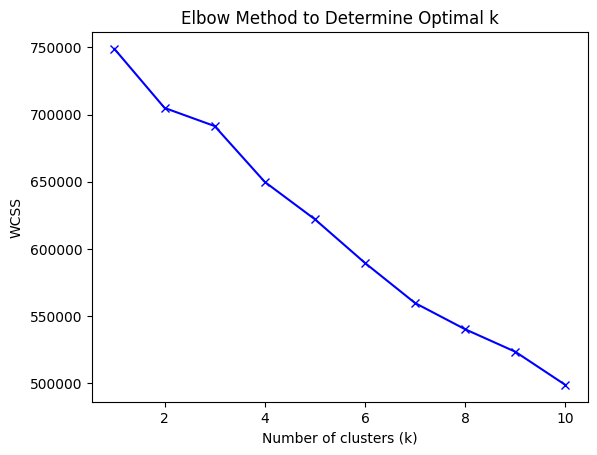

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ssd = []
K = range(1, 11)  # Number of clusters to try
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    ssd.append(kmeans.inertia_)  # SSD

# Plot the elbow curve
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal k')
plt.show()


### 2. Silhouette Score
- **Definition**: Silhouette Score measures how well-separated the clusters are by considering both intra-cluster cohesion and inter-cluster separation.
- **Purpose**: Higher values (close to 1) indicate better-defined clusters.
- **Formula**:$
  S(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
  $
  where:
  - $a(i)$: Average distance of a point $i$ to other points in the same cluster (cohesion).
  - $b(i)$: Average distance of a point $i$ to points in the nearest cluster (separation).


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 11)  # Silhouette is undefined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method to Determine Optimal k')
plt.show()


### 3. Elbow Method (SSD/WCSS) vs. Silhouette Method

Plotting this two methods together we have a sort of trade-off between those two,


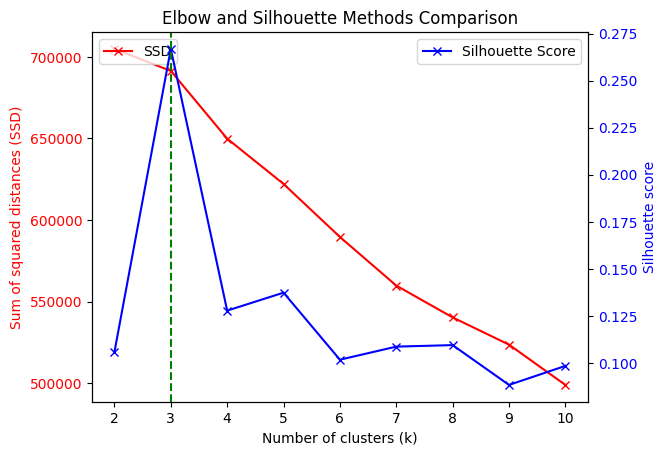

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize variables
ssd = []
silhouette_scores = []
K = range(2, 11)  # Range of clusters (start from 2 for silhouette)

# Calculate SSD and Silhouette Scores for each k
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    ssd.append(kmeans.inertia_)  # Sum of squared distances (SSD)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Plot the results
fig, ax1 = plt.subplots()

# Plot SSD (Elbow Method)
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Sum of squared distances (SSD)', color='red')
ax1.plot(K, ssd, 'rx-', label='SSD')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc="upper left")

# Create a second y-axis for Silhouette Scores
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette score', color='blue')
ax2.plot(K, silhouette_scores, 'bx-', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc="upper right")

# Highlight key points
optimal_k_silhouette = np.argmax(silhouette_scores) + 2  # Add 2 because range starts at 2
plt.axvline(x=optimal_k_silhouette, color='green', linestyle='--', label=f'Peak Silhouette (k={optimal_k_silhouette})')

# Add a title
plt.title('Elbow and Silhouette Methods Comparison')
plt.show()

In [ ]:
## 4. Gap Statistic
- **Definition**: Compares the WCSS for the actual data to WCSS for random data with the same dimensions, identifying how much better clustering is compared to randomness.
- **Purpose**: Looks for a significant "gap" between the two values to determine the optimal \(k\).
- **Steps**:
  1. Calculate WCSS for the actual data for different \(k\).
  2. Generate random datasets and compute WCSS for the same \(k\).
  3. Compute the gap:
     \[
     \text{Gap} = \log(\text{WCSS}_{\text{random}}) - \log(\text{WCSS}_{\text{data}})
     \]
- **Optimal \(k\)**: Largest gap or where the gap starts to decrease.


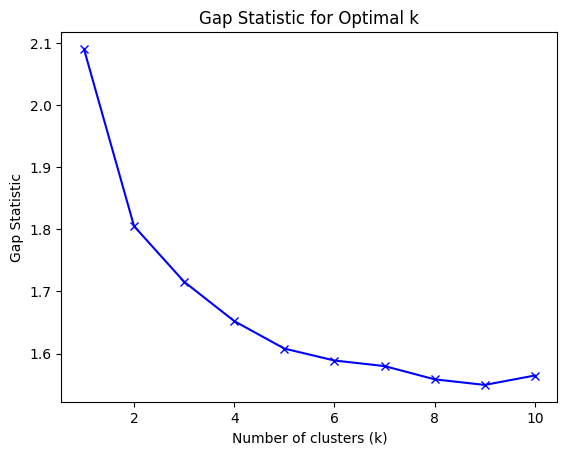

Optimal number of clusters: 1


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

def gap_statistic(data, max_k=10, n_refs=10):
    gaps = []
    for k in range(1, max_k + 1):
        # Fit KMeans for actual data
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        actual_wcss = kmeans.inertia_

        # WCSS for random reference data
        refs = np.random.uniform(data.min(axis=0), data.max(axis=0), size=(data.shape[0], data.shape[1]))
        ref_wcss = [KMeans(n_clusters=k, random_state=42).fit(refs).inertia_ for _ in range(n_refs)]

        # Compute the gap
        gaps.append(np.log(np.mean(ref_wcss)) - np.log(actual_wcss))

    # Plot the gap statistic
    plt.plot(range(1, max_k + 1), gaps, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic for Optimal k')
    plt.show()
    return np.argmax(gaps) + 1  # Optimal k

# Example usage
optimal_k = gap_statistic(scaled_features, max_k=10)
print(f"Optimal number of clusters: {optimal_k}")


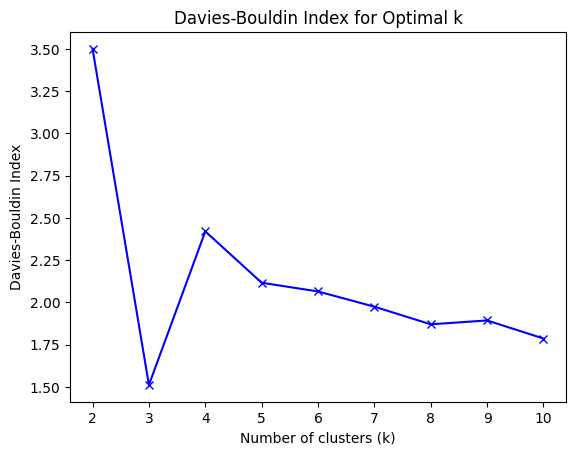

Optimal number of clusters based on Davies-Bouldin Index: 3


In [ ]:
from sklearn.metrics import davies_bouldin_score

# Compute Davies-Bouldin Index for different k
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_features)
    labels = kmeans.labels_
    db_scores.append(davies_bouldin_score(scaled_features, labels))

# Plot Davies-Bouldin Index
plt.plot(range(2, 11), db_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal k')
plt.show()

optimal_k_db = np.argmin(db_scores) + 2
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k_db}")


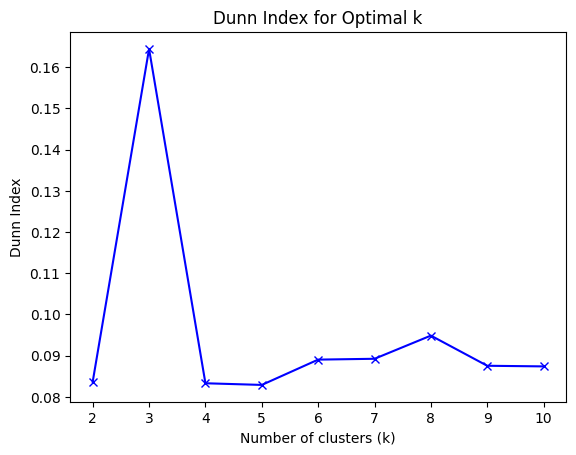

Optimal number of clusters based on Dunn Index: 3


In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    centroids = [data[labels == label].mean(axis=0) for label in unique_labels]

    # Compute inter-cluster distances
    inter_distances = cdist(centroids, centroids)
    np.fill_diagonal(inter_distances, np.inf)  # Exclude self-distances
    min_inter_distance = np.min(inter_distances)

    # Compute intra-cluster distances
    intra_distances = [np.max(cdist(data[labels == label], [centroid]))
                       for label, centroid in zip(unique_labels, centroids)]
    max_intra_distance = np.max(intra_distances)

    return min_inter_distance / max_intra_distance

# Compute Dunn Index for different k
dunn_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_features)
    labels = kmeans.labels_
    dunn_scores.append(dunn_index(scaled_features, labels))

# Plot Dunn Index
plt.plot(range(2, 11), dunn_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Dunn Index')
plt.title('Dunn Index for Optimal k')
plt.show()

optimal_k_dunn = np.argmax(dunn_scores) + 2
print(f"Optimal number of clusters based on Dunn Index: {optimal_k_dunn}")
